In [1]:
from synthetix_v3.base_perps import BasePerps
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
base_perp = BasePerps()

### get market info

In [3]:
market_price_df = base_perp.get_market_updates()

In [4]:
market_price_df.columns

Index(['marketUpdateds_timestamp', 'markets_id', 'marketUpdateds_price',
       'marketUpdateds_skew', 'marketUpdateds_size',
       'marketUpdateds_sizeDelta', 'marketUpdateds_currentFundingRate',
       'marketUpdateds_currentFundingVelocity', 'markets_marketSymbol'],
      dtype='object')

In [14]:
market_price_polars_df = pl.from_pandas(market_price_df).with_columns([
    pl.from_epoch('marketUpdateds_timestamp').dt.round("1s").alias('datetime'),
    pl.col('marketUpdateds_price') / 10**18,
    pl.col('marketUpdateds_skew') / 10**18,
    pl.col('marketUpdateds_size') / 10**18,
    pl.col('marketUpdateds_sizeDelta') / 10**18,
    pl.col('marketUpdateds_currentFundingRate') / 10**18,
    pl.col('marketUpdateds_currentFundingVelocity') / 10**18
])

In [15]:
market_price_polars_df.head(5)

marketUpdateds_timestamp,markets_id,marketUpdateds_price,marketUpdateds_skew,marketUpdateds_size,marketUpdateds_sizeDelta,marketUpdateds_currentFundingRate,marketUpdateds_currentFundingVelocity,markets_marketSymbol,datetime
i64,i64,f64,f64,f64,f64,f64,f64,str,datetime[μs]
1697325288,100,1556.300977,-6946.416037,19743.59138,1284.8751,0.012155,-0.062518,"""ETH""",2023-10-14 23:14:48
1697321028,300,7.308,-6688.146558,33222.967442,-6823.8774,-0.004412,-0.012039,"""LINK""",2023-10-14 22:03:48
1697318570,300,7.32966,135.730842,40046.844842,6823.8774,-0.004419,0.000244,"""LINK""",2023-10-14 21:22:50
1697317636,100,1558.04251,-8231.291137,21028.46648,1561.9509,0.018716,-0.074082,"""ETH""",2023-10-14 21:07:16
1697317154,100,1555.45582,-9793.242037,22590.41738,-10000.0,0.019208,-0.088139,"""ETH""",2023-10-14 20:59:14


### get position liquidations

In [16]:
pos_liqs_df = base_perp.get_position_liquidations()

In [17]:
position_liquidations_df = pl.from_pandas(pos_liqs_df)

In [18]:
position_liquidations_df = position_liquidations_df.with_columns([
    pl.from_epoch('positionLiquidateds_timestamp').dt.round("1s").alias('datetime'),
    pl.col('positionLiquidateds_amountLiquidated') / 10**18,
    pl.col('positionLiquidateds_currentPositionSize') / 10**18,
    ]).filter(pl.col("datetime") > datetime(2023, 10, 2))

In [19]:
joined_data = position_liquidations_df.join(market_price_polars_df, on='datetime', how='left')

In [21]:
print(position_liquidations_df.shape)
print(market_price_polars_df.shape)

(153, 8)
(2343, 10)


In [26]:
joined_subset_data = joined_data.select(
    'datetime', 
    'markets_marketSymbol', 
    'positionLiquidateds_accountId', 
    'positionLiquidateds_amountLiquidated', 
    'positionLiquidateds_currentPositionSize', 
    'marketUpdateds_price'
    ).sort(by='datetime', descending=True)

In [33]:
market_price_polars_df

marketUpdateds_timestamp,markets_id,marketUpdateds_price,marketUpdateds_skew,marketUpdateds_size,marketUpdateds_sizeDelta,marketUpdateds_currentFundingRate,marketUpdateds_currentFundingVelocity,markets_marketSymbol,datetime
i64,i64,f64,f64,f64,f64,f64,f64,str,datetime[μs]
1697325288,100,1556.300977,-6946.416037,19743.59138,1284.8751,0.012155,-0.062518,"""ETH""",2023-10-14 23:14:48
1697321028,300,7.308,-6688.146558,33222.967442,-6823.8774,-0.004412,-0.012039,"""LINK""",2023-10-14 22:03:48
1697318570,300,7.32966,135.730842,40046.844842,6823.8774,-0.004419,0.000244,"""LINK""",2023-10-14 21:22:50
1697317636,100,1558.04251,-8231.291137,21028.46648,1561.9509,0.018716,-0.074082,"""ETH""",2023-10-14 21:07:16
1697317154,100,1555.45582,-9793.242037,22590.41738,-10000.0,0.019208,-0.088139,"""ETH""",2023-10-14 20:59:14
1697309220,200,26876.595,0.021517,396.680828,29.7651,0.004429,1.9365e-7,"""BTC""",2023-10-14 18:47:00
1697309180,100,1553.875,206.757963,12590.41738,-514.7804,0.019036,0.001861,"""ETH""",2023-10-14 18:46:20
1697309104,100,1554.242913,721.538363,12075.63698,-321.7048,0.019031,0.006494,"""ETH""",2023-10-14 18:45:04
1697309060,500,1.8654542,39655.124171,550765.48633,42829.368,-0.03194,0.356896,"""SNX""",2023-10-14 18:44:20


Text(0.5, 1.0, 'eth market updates')

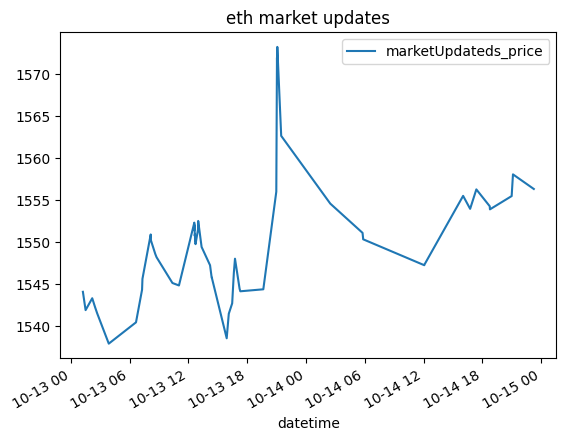

In [32]:
market_price_polars_df.filter(
    pl.col('markets_marketSymbol') == 'ETH'
    ).filter(
        pl.col('datetime') > datetime(2023, 10, 13)
        ).to_pandas().plot(kind='line', x='datetime', y='marketUpdateds_price')
plt.title('eth market updates')

Text(0.5, 1.0, 'eth market updates')

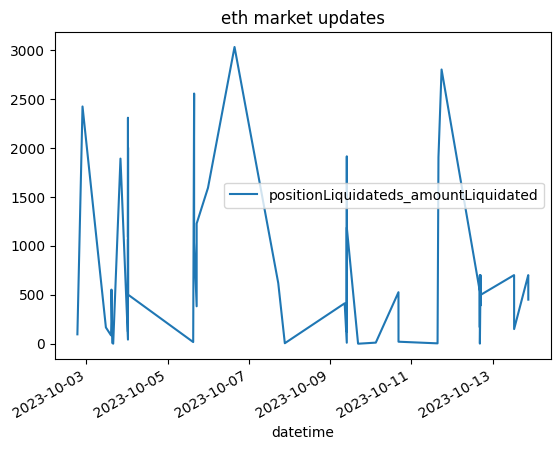

In [31]:
joined_subset_data.filter(
    pl.col('markets_marketSymbol') == 'ETH'
    ).to_pandas().plot(kind='line', x='datetime', y='positionLiquidateds_amountLiquidated')
plt.title('eth market updates')

In [ ]:
grouped_df = (
    position_liquidations_df.sort(by="datetime", descending=True)
    .with_columns(pl.col("datetime").dt.round("1s"))
    .group_by("datetime", "markets_marketSymbol")
    .agg([pl.count()])
    .filter(pl.col("datetime") > datetime(2023, 10, 2))
)

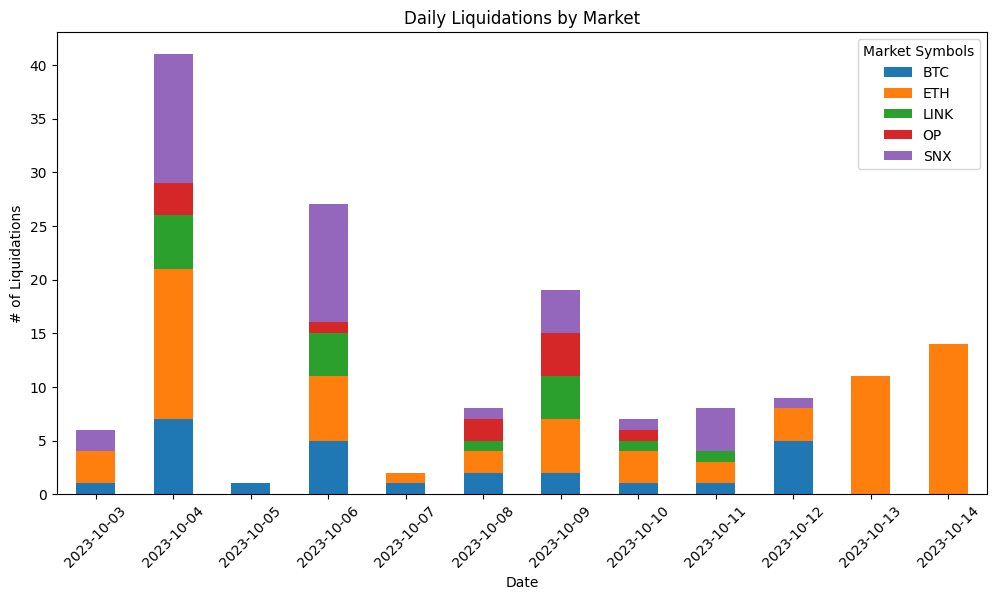

In [ ]:
# Pivot the DataFrame to create a stacked bar plot
pivot_df = grouped_df.to_pandas().pivot(index='datetime', columns='markets_marketSymbol', values='count').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("# of Liquidations")
ax.set_title("Daily Liquidations by Market")

# Format the x-axis labels to display only the date
date_format = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_format)

plt.xticks(range(len(pivot_df.index)), [ts.strftime('%Y-%m-%d') for ts in pivot_df.index], rotation=45)
plt.legend(title="Market Symbols")
plt.show()